In [1]:
# old

import wikipedia
import requests
from bs4 import BeautifulSoup
from gensim.summarization import keywords

### Getting Data
For this project, all data will be found on publicly available web pages. I'll be using the `requests` and `bs4` modules to acquire data. 

My goal is to make this project generalizable and able to work with any list of webpages/URLs. Because of this, I'm focusing on understanding how to work with a small dataset of a few wiki pages for now.

Eventually, I will separate the scraping portion into a script and create a `data/` directory, but that isn't necessary for now.

### Sharing Data
Because all of the data I'm using is publicly available on the internet, everyone will have access to all of my data. It will all be either scraped data or built-in corpora (like `gensim.corpora.wikicorpus`). The `data/` directory will probably eventually be gitignored, but I running this notebook will generate everything in `data/`.

In [2]:
# this can get the data we need
def _get_with_requests(link): 
    import lxml
    req = requests.get(link).text
    soup = BeautifulSoup(req, "html.parser")
    # remove javascript/css 
    [s.decompose() for s in soup.findAll(['script', 'style'])] 
    
    return soup.text

def get_topics(content):
    '''
    takes string of content and returns list of keywords
    '''
    # definitely need to look into more interesting data to rank keywords
    # what exactly does words do... https://radimrehurek.com/gensim/summarization/keywords.html
    return keywords(content, words=20, lemmatize=True).split('\n')

In [20]:
'''
Pretend we have a list of topics, say Apple, Orange, Yankees, Red Sox. 
Get data, figure out topics, and group.
'''
# for wikipedia pages, use wikipedia api to guarantee nice data
import os
pages = ['Apple', 'Orange_(fruit)', 'Grapefruit', 'Yankees', 'Red_Sox', 'Chicago_Cubs', 'Baseball', 'Tree']
pages_content = {}
for page in pages:
    path = 'data/scraped_wiki/{}.txt'.format(page)
    if not os.path.isfile(path):
        content = wikipedia.page(page).content
        with open(path, 'w') as f:
            f.write(content)
        pages_content[page] = content
    else:
        with open(path, 'r') as f:
            pages_content[page] = f.read() 

In [21]:
# Extract topics from each page
# Topics will be used for section naming, not for grouping. Grouping w/ paragraph2vec?
page_topics = {page:get_topics(content) for page, content in pages_content.items()}

### Stats
This project is designed to be generic and should work for any list of URLs (with varying success, of course).
This section prints some stats and visualizes the topics.

In [22]:
print('total pages:', len(pages))
topic_pages = {}
for page, topics in page_topics.items():
    print('page: ', page)
    print('\ttopics:', topics)
    for topic in topics:
        if topic not in topic_pages:
            topic_pages[topic] = [page]
        else:
            topic_pages[topic].append(page)
for topic, pages in topic_pages.items():
    print('\ntopics:', topic)
    print('\tpages:', pages)
    

total pages: 8
page:  Apple
	topics: ['apple', 'fruits', 'cultivars', 'trees', 'including', 'malus', 'davidson', 'diseases', 'years', 'organic', 'general', 'groups', 'pollination', 'sweet', 'producers', 'like', 'goddesses', 'days', 'high', 'storage']
page:  Yankees
	topics: ['yankees', 'teamed', 'season', 'news', 'home games', 'pitchers', 'league', 'baseball', 'year', 'series', 'wins record', 'playing', 'manage', 'sports', 'player', 'hitting', 'second', 'steinbrenner']
page:  Chicago_Cubs
	topics: ['cubs', 'game', 'season', 'chicago', 'teams', 'league', 'year', 'recordings', 'fields', 'winning', 'playing', 'manage', 'baseball', 'series', 'home', 'players', 'wrigley', 'clubs', 'fan', 'parking']
page:  Grapefruit
	topics: ['grapefruits', 'hybrids', 'citrus', 'drugs', 'sweets', 'red', 'variety', 'contain', 'fruit', 'pummelo', 'colors', 'orange', 'origin', 'commercial', 'probable', 'white', 'tangerine', 'effects', 'pink', 'care']
page:  Orange_(fruit)
	topics: ['orangers', 'grown', 'fruits

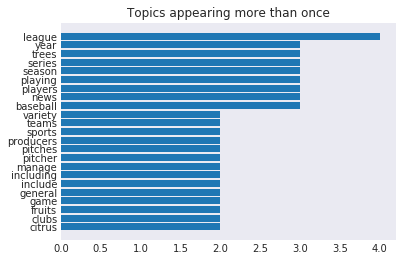

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_style('dark')

topic_list = []
num_pages = []
for topic, pages in topic_pages.items():
    if len(pages) > 1:
        topic_list.append(topic)
        num_pages.append(len(pages))
sorted_pages = sorted(zip(num_pages, topic_list))
num_pages = [x[0] for x in sorted_pages]
topic_list = [x[1] for x in sorted_pages]
plt.barh(np.arange(len(topic_list)), num_pages)
plt.yticks(np.arange(len(topic_list)),topic_list)
plt.title('Topics appearing more than once')
plt.show()


In [24]:
# Are apple/grapefruit/lemon all under fruit?
print(topic_pages['fruit'])

['Grapefruit']


In [25]:
# nope.
# print(topic_pages['fruits'])
# looks like the lemmatize param in gensim keywords() does some weird stuff.

Note: Sometimes words will get lemmatized differently and the three fruits won't necessarily be grouped under 'fruit'. Sometimes there is 'fruit' and 'fruits'...

Gensim lemmatizer isn't consistent.


In [26]:
print(topic_pages['baseball'])

['Yankees', 'Chicago_Cubs', 'Baseball']


And apparently Red Sox doesn't even have the keyword baseball..